<a href="https://colab.research.google.com/github/muskan1802/Document_Scanner/blob/master/img_cap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/muskan1802/Image_Captioning.git

Cloning into 'Image_Captioning'...
remote: Enumerating objects: 8128, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 8128 (delta 5), reused 12 (delta 3), pack-reused 8114
Receiving objects: 100% (8128/8128), 1.03 GiB | 23.54 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (8107/8107), done.


In [2]:
!python main.py --foo bar

python3: can't open file 'main.py': [Errno 2] No such file or directory


In [3]:
!pip install vocabulary

     |████████████████████████████████| 584 kB 11.6 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
     |████████████████████████████████| 111 kB 51.6 MB/s 
  Created wheel for vocabulary: filename=Vocabulary-1.0.4-py3-none-any.whl size=12312 sha256=9e01ca7f00e1f31c0b22861924701d4f204e20067f32d48ee9ab425dc62eb091
  Stored in directory: /root/.cache/pip/wheels/8f/4d/20/82129312946253496e03222c7f97a3b3f3040094c8c69a59c8
Successfully built vocabulary
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.0.1 requires requests>=2.19.0, but you have requests 2.13.0 which is incompatible.
tensorboard 2.6.0 requires requests<3,>=2.21.0, but you have requests 2.13.0 which is inco

<class 'dict'>


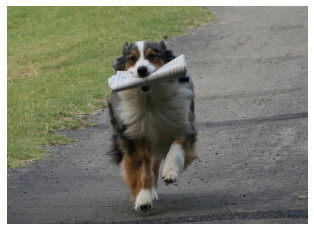

In [6]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model,load_model
from keras.preprocessing.sequence import  pad_sequences
import vocabulary
from tensorflow.keras.utils import to_categorical
from keras.layers import Input,Dense,Dropout,Embedding,LSTM
from keras.layers.merge import  add


def readTExtFile(path):
    with open(path) as f:
        captions = f.read()
    return captions
captions = readTExtFile("Image_Captioning/archive/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
# print(len(captions.split("\n")))
captions = captions.split('\n')[:-1]
# print(len(captions))

#dictionary to map each image with the list of captions it has

description = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]

    #if image id is already present or not
    if description.get(img_name) is None:
        description[img_name] = []

    description[img_name].append(second)

# print(description["1000268201_693b08cb0e"])
IMG_PATH = "Image_Captioning/archive/Flickr_Data/Images/"

img = cv2.imread(IMG_PATH + "2089122314_40d5739aef.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
# plt.show()

#DATA CLEANING
# all lower case, remove numbers, remove punctuations , reduce cab size , less overfitting less computation

def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()

    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

# print(clean_text("A cat is sitting over the house # 64"))

# clean all captions
for key,caption_list in description.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i]) # iterating over images and clean the caption

# print(description["1000268201_693b08cb0e"])

#write the data to text file

with open("description.txt","w") as f:
    f.write(str(description))

#vocabulary
#vocab - set of all unique words your model can predict because we going to  make a mapping of word

description = None
with open("description.txt",'r') as f:
    description = f.read()

# Java Script Object Notation (JSON) is a light weight data format with many similarities to python dictionaries.
# JSON objects are useful because browsers can quickly parse them, which is ideal for transporting data between a client and a server.

json_acceptable_string = description.replace("'","\"")
description = json.loads(json_acceptable_string)
print(type(description))

#vocab

vocab = set()
for key in description.keys():
    [vocab.update(sentence.split()) for sentence in description[key]]

# print("Vocab size : %d"% len(vocab))

#total words across all the sentences

total_words = []
for key in description.keys():
    [total_words.append(i) for des in description[key] for i in des.split()]

# print("Total words %d"%len(total_words))

#shorten program - filter words from the vocab according to the certain threshold frequency

import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
# print(freq_cnt)

#short this dictionary according to the freq count

sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

#filter
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

# print(len(total_words))  #removed duplicates(unique words) , sorted using frequency

#Prepare train/test model

train_file_data = readTExtFile("Image_Captioning/archive/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTExtFile("Image_Captioning/archive/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

train = [row.split(".")[0] for row  in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row  in test_file_data.split("\n")[:-1]]

#prepare description for the training data
# tweak - add start (<s>) and end (<e>) token to our training data

train_description = {}
for img_id in train :
    train_description[img_id] = []
    for cap in description[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_description[img_id].append(cap_to_append)

# print(train_description["1000268201_693b08cb0e"])

#transfer learning : image->features , text->features
# step-1 : image feature extraction(resnet50 is pretrained model have 50 layers , has skip connection , gradients can flow and can back propogate easily

model = ResNet50(weights="imagenet",input_shape=(224,224,3))
# print(model.summary())
#instead of taking entire model we'll be using convolutional base
model_new = Model(model.input,model.layers[-2].output)
#preprocess some images where resnet50 expect it to be and then we'll store those image to compute image-feature

def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0) # when we load img it is of 224,224,3 when we feed image in model eg resnet50 we can't feed single img it should be of some batch - 4D tensor(3D to 4D)
    #Normalisation
    img = preprocess_input(img)
    return img

# img = preprocess_img(IMG_PATH + "1000268201_693b08cb0e.jpg")
# plt.imshow(img[0])
# plt.show()

def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    # print(feature_vector.shape)
    return feature_vector

# print(encode_image(IMG_PATH + "1000268201_693b08cb0e.jpg"))

# start = time()
# encoding_train = {}
# #image_id -> feature_vector extracted from resnet image

# for ix,img_id in enumerate(train):
#     img_path = IMG_PATH+"/"+img_id+".jpg"
#     encoding_train[img_id] = encode_image(img_path)

#     if ix%100 == 0:
#         print("Encoding in Progress Time step %d "%ix)

# end_t = time()
# print("Total time taken :", end_t-start)

# #stroe everything to the disk - pickle is used for that allows us to convert (store ram data to disk)

# with open("encoded_train_features.pkl","wb") as f:
#     pickle.dump(encoding_train,f)

# start_t = time()
# encoding_test = {}
# #image_id -> feature_vector extracted from resnet image

# for ix,img_id in enumerate(test):
#     img_path = IMG_PATH+"/"+img_id+".jpg"
#     encoding_test[img_id] = encode_image(img_path)

#     if ix%100 == 0:
#         print("Test Encoding in Progress Time step %d "%ix)

# end_tt = time()
# print("Total time taken(test) :", end_tt-start_t)

# #store everything to the disk - pickle is used for that allows us to convert (store ram data to disk)

# with open("encoded_test_features.pkl","wb") as f:
#     pickle.dump(encoding_test,f)

# DATA PER-PROCESSING FOR CAPTIONS - since every word is a feature and it needs to be represented using no

#Vocab

word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i
    idx_to_word[i+1] = word

#Two special words

idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx)+1
# print("vocab_size",vocab_size)
max_len=0
for key in train_description.keys():
    for cap in train_description[key]:
        max_len = max(max_len,len(cap.split()))

## Data Loader(GENERATOR)
#language modeling - P(wt+1|w1....wt)

def data_generator(train_description,encoding_Train,word_to_idx,max_len,batch_size):
    x1,x2,y = [],[],[]

    n=0

    while True:
        for key,desc_list in train_description.items():
            n+=1

            photo = encoding_Train[key+'.jpg']
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    x1 = seq[0:i]
                    yi = seq[i]

                    #0 denote padding word - post means after the sequence 0 is added
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]

                    x1.append(photo)
                    x2.append(xi)
                    y.append(yi)

                if n==batch_size:
                    yield [[np.array(x1),np.array(x2)],np.array(y)]

                    x1,x2,y = [],[],[]
                    n=0






In [ ]:
## WORD EMBEDDINGS - Glove Embedding(6B50D.txt)
f = open("glove.6B.50d.txt",encoding='utf8')
embedding_index={}

for line in f:
    values = line.split()

    word = values[0]
    embedding_word = np.array(values[1:],dtype='float')
    embedding_index[word] = embedding_word
f.close()
#print(embedding_index['apple'])

def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)

        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix

embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

# MODEL ARCHITECTURE


In [ ]:

#for images
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

# captions as input

input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

#combine model

model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

#Important thing

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy',optimizer="adam")




In [ ]:
#Training of Model

epochs = 20
batch_size = 3
steps = len(train_description)//batch_size

# def train():
#     for i in range(epochs):
#         generator = data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size)
#         Model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
#         Model.save('./model_weights/model_'+str(i)+'.h5')
for i in range(epochs):
  generator = data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
  model.save('Image_Captioning/model_'+str(i)+'.h5')

In [ ]:
model = load_model("Image_Captioning/model_9.h5")

In [ ]:
#PREDICTION

# def predict_caption(photo):

#   in_text = "startseq"
#   for i in range(max_len):
#     sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
#     sequence = pad_sequences([sequence],maxlen=max_len,padding='post')

#     ypred = model.predict([photo,sequence])
#     ypred = ypred.argmax() #word with max prob always - greedy sampling
#     word = idx_to_word[ypred]
#     in_text += ' ' + word
#     if word == 'endseq':
#       break

#     # final_caption = in_text.split()[1:-1]
#     # final_caption = ' '.join(final_caption)
#     final_caption =  in_text.split()
#     final_caption = final_caption[1:-1]
#     final_caption = ' '.join(final_caption)

#     return final_caption

def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()[1:-1]
    #final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

In [ ]:
#pick some random images and see result

for i in range(2):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread("Image_Captioning/archive/Flickr_Data/Images/"+img_name+".jpg")
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)
# for i in range(2):
#   idx = np.random.randint(0,1000)
#   all_img_names = list(encoding_test.keys())
#   img_name = list(encoding_test.keys())[idx]
#   photo_2048 = encoding_test[img_name].reshape((1,2048))
  
#   i = plt.imread("Image_Captioning/archive/Flickr_Data/Images/"+img_name+".jpg")
#   plt.imshow(i)
#   plt.axis('off')
#   plt.show()
#   caption = predict_caption(photo_2048)
#   print(caption)